In [1]:
!pip install rembg==2.0.56

# Imports

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from rembg import new_session, remove

# Constants

In [3]:
BASE_PATH = '/kaggle/input/key-images/'

# Model

In [4]:
class ImageModel:
    def __init__(self, rgb_img, mask_img, cropped_mask=None, feature_img=None):
        self.rgb_img = rgb_img            # RGB Original Img
        self.mask_img = mask_img          # Binary Img
        self.cropped_mask = cropped_mask  # Cropped Mask
        self.feature_img = feature_img    # Grayscaled image with textured

# Helper Functions

In [33]:
def extract_key_boundary_from_masked_img(masked_img):
    # Convert image to numpy
    gray_img = np.array(key_images[-2].mask_img)

    # Remove noise using Gaussian blur
    blurred_image = cv2.GaussianBlur(gray_img, (5, 5), 0)

    # Detect edges using Canny edge detection
    edges = cv2.Canny(blurred_image, 30, 150)
    
    return edges


def resize_binary_image(image):
    WIDTH = 488
    HEIGHT = 488
    PADDING = 12
    
    # Get the original image dimensions
    original_height, original_width = image.shape[:2]

    # Calculate the scaling factor for both dimensions
    scale_x = WIDTH / original_width
    scale_y = HEIGHT / original_height

    # Choose the smaller scaling factor to maintain aspect ratio
    scale = min(scale_x, scale_y)

    # Resize the image using the calculated scaling factor
    resized_image = cv2.resize(image, None, fx=scale, fy=scale)

    # Create a blank canvas of the desired size
    canvas = np.zeros((HEIGHT + 2*PADDING, WIDTH + 2*PADDING), dtype=np.uint8)

    # Calculate the offset to center the resized image on the canvas
    offset_x = (canvas.shape[1] - resized_image.shape[1]) // 2
    offset_y = (canvas.shape[0] - resized_image.shape[0]) // 2

    # Paste the resized image onto the canvas
    canvas[offset_y:offset_y+resized_image.shape[0], offset_x:offset_x+resized_image.shape[1]] = resized_image

    return canvas

In [6]:
def load_general_use_model(model_name='isnet-general-use'):
    '''
    Parameters:
    model_name: str
    '''
    session = new_session(model_name)
    return session


def remove_bg(input_img, only_mask=False):
    '''
    Remove background for single images
    '''
    # Make session
    session_isnet_general_use = load_general_use_model()

    # Output image
    output_img = remove(input_img,
                        session=session_isnet_general_use,
                        only_mask=only_mask)
    return output_img


def get_dataset_images_path(base_path):
    image_names = []
    images_path = []
    for _, _, img_names in os.walk(base_path):
        image_names.extend(img_names)
    
    images_path = [os.path.join(base_path, img_name) for img_name in image_names]
    return images_path


def plt_img(img_data, cmap='viridis'):
    '''
    cmap:
      * 'gray' (Grayscale)
      * 'binary' (Binary)
    '''
    plt.imshow(img_data, cmap=cmap)
    plt.axis('on')
    plt.show()

# Step 1: Mask Keys in image

In [8]:
# 1. Get images path
images_path = sorted(get_dataset_images_path(BASE_PATH))

# 2. Read images
key_images = []
for image_path in images_path:
    # 2a. Read img as PIL.Image
    rgb_img = Image.open(image_path)
    
    # 2b. Convert rgb to mask
    grayscale_mask = remove_bg(rgb_img, only_mask=True)
    
    # 2c. Convert masked image to binary mask
    grayscale_mask = np.array(grayscale_mask)
    _, mask_img = cv2.threshold(grayscale_mask, 127, 255, cv2.THRESH_BINARY)
    
    # 2d. Cropped masked img
    contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    x,y,w,h = cv2.boundingRect(contours[0])
    cropped_mask = mask_img[y:y+h, x:x+w]
    
    key_images.append(
        ImageModel(rgb_img=np.array(rgb_img),
                   mask_img=mask_img,
                   cropped_mask=cropped_mask)
    )

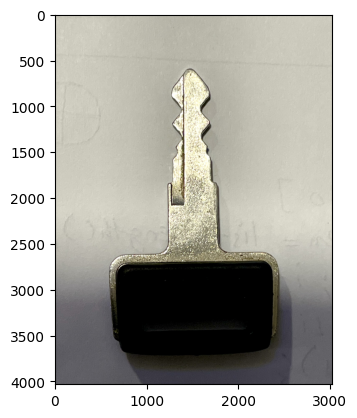

In [9]:
plt_img(key_images[0].rgb_img)

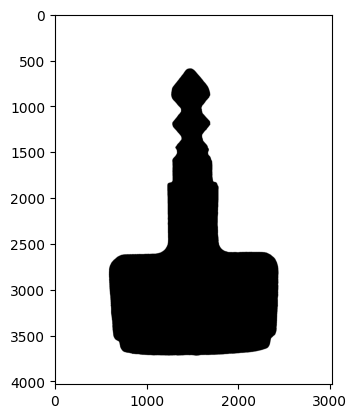

In [10]:
plt_img(key_images[0].mask_img, cmap='binary')

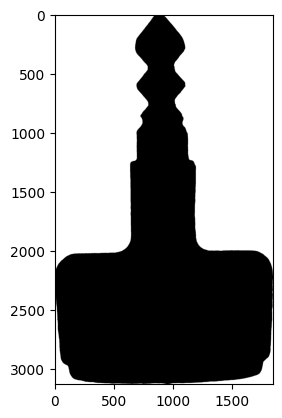

In [13]:
plt_img(key_images[0].cropped_mask, cmap='binary')

# Step2: Transform Image (Rotation)

In [38]:
image = key_images[0].cropped_mask

# Find contours
contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Approximate the contour to get the key's main shape
approx = cv2.approxPolyDP(contours[0], 0.01 * cv2.arcLength(contours[0], True), True)

# Compute the minimum area bounding rectangle around the contour
rect = cv2.minAreaRect(approx)
box = cv2.boxPoints(rect)
box = np.int0(box)

# Determine the angle of rotation needed to align the rectangle with the desired orientation
angle = rect[2]

# Rotate the image by the calculated angle to align the key's teeth with the right side
(h, w) = image.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)


/tmp/ipykernel_142/2707412908.py:12: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


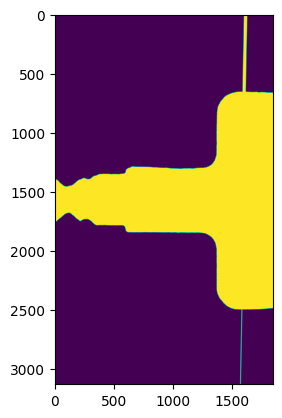

In [39]:
plt_img(rotated)

# Step3: Resize keys to 512x512

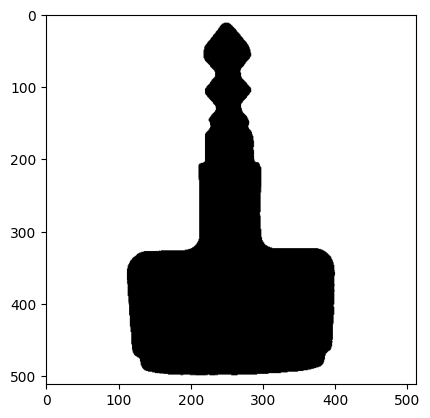

In [37]:
new_img = resize_binary_image(key_images[0].cropped_mask)
plt_img(new_img, cmap='binary')

In [32]:
new_img.shape

(512, 512)